# Part II - Cross Validation and Model Building

### Imports

#### Essentials

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

import pandas as pd
pd.set_option("display.max_columns", None)

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from plotly import express as px

rs=1219

#### Models and Functions

In [3]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import mutual_info_regression

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet, Lars, RANSACRegressor, HuberRegressor
from sklearn.svm import SVR

import optuna

### Additional functions

In [4]:
def remove_outliers(df, features, low=0.25, high=0.75, sen=1.5):
    '''
    Arguments:
    - Takes dataframe, features as a list
    - (Optional) Lower and upper quantile ranges and sesnitivity
    '''
    for col in features:
        print('Currently removing outliers from: {}'.format(col))
        q1 = df[col].quantile(low)
        q3 = df[col].quantile(high)
        iqr = q3 - q1
        lower_bound = (q1 - (sen*iqr))
        upper_bound = (q3 + (sen*iqr))
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
    return df


from sklearn.metrics import mean_squared_error

def rmse(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(abs(mean_squared_error(y, y_pred)))

def rmse_score(y_true, y_pred):
    return np.sqrt(abs(mean_squared_error(y_true, y_pred)))

### Training data from Kaggle

In [5]:
train = pd.read_csv("../input/regressionproblem/data.csv")

### Data preparation

#### First stage outlier removal

In [6]:
l, h = 0.15, 0.85
features = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
train_clean = remove_outliers(df=train, features=features, low=l, high=h)

Currently removing outliers from: x0
Currently removing outliers from: x1
Currently removing outliers from: x2
Currently removing outliers from: x3
Currently removing outliers from: x4
Currently removing outliers from: x5
Currently removing outliers from: x6
Currently removing outliers from: x7
Currently removing outliers from: x8
Currently removing outliers from: x9


In [7]:
train_clean.reset_index()

,index,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,0,9214,-1.269584,-0.471276,1.271286,1.181464,-0.100392,1.449701,1.377916,-0.065368,-0.292402,-0.227562,-6.744388
1,1,9936,-3.345712,0.962012,-0.010381,-1.143822,2.144663,0.002984,-0.062975,0.239043,1.026711,0.937543,-209.017251
2,2,6148,-0.177312,-0.654352,1.139073,0.449924,-0.428796,0.956123,1.523470,-0.016801,0.279851,-0.183580,136.280877
3,3,3466,-0.465802,1.430401,0.565258,-0.882161,0.228255,-0.579749,1.538078,2.194240,-0.029758,0.686409,92.047959
4,4,6878,1.145984,0.663759,1.589677,0.773086,0.838778,1.354121,-0.156710,-0.403062,0.140580,-1.136642,91.349775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11992,11995,9941,1.209148,0.968248,-0.233942,-0.661826,0.068980,1.038689,1.342263,-0.475022,0.024588,-0.071629,216.940422
11993,11996,3835,-0.202524,-0.876634,-0.379980,1.378035,-0.602254,-1.158553,1.115208,0.291473,1.088164,-1.236181,156.244277
11994,11997,6101,0.577834,1.112086,-0.697342,0.123455,0.444490,-0.668361,-1.891849,0.695727,0.929277,-0.183775,-49.257565
11995,11998,5435,-0.315841,-0.391228,-0.213742,-0.171128,1.823233,1.261355,1.930175,0.929642,-0.181617,2.091590,127.117060


In [8]:
train_clean.shape

(11997, 12)

In [9]:
X, y = train_clean.iloc[:,1:-1], train_clean.iloc[:,-1]

### Feature importances

In [10]:
importances = mutual_info_regression(X, y)
feat_importances = pd.Series(importances, index=features[:len(features)])
print(feat_importances)

x0    0.238049
x1    0.000000
x2    0.000000
x3    0.000000
x4    0.000000
x5    0.000000
x6    0.259149
x7    0.012739
x8    0.165091
x9    0.000000
dtype: float64


#### Importance Breakdown

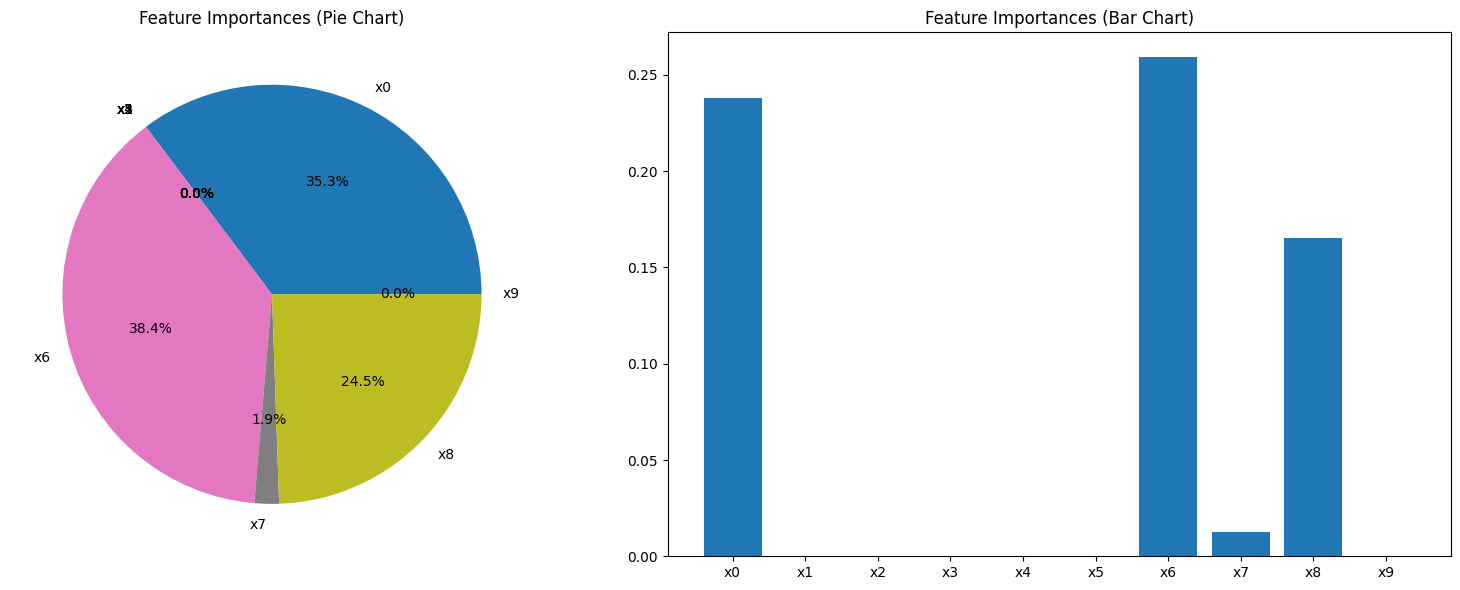

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].pie(feat_importances, labels=feat_importances.index, autopct='%1.1f%%')
axes[0].set_title('Feature Importances (Pie Chart)')

axes[1].bar(feat_importances.index, feat_importances.values)
axes[1].set_xticklabels(feat_importances.index, rotation='horizontal')
axes[1].set_title('Feature Importances (Bar Chart)')

plt.tight_layout()
plt.show()

### K-Folds

In [12]:
n_splits=13
fold=1

kf = KFold(n_splits=n_splits, shuffle=True, random_state=rs)

for train_idx, test_idx in kf.split(X, y):
    print(f'Fold {fold}: Train: {len(train_idx)}; Test:{len(test_idx)}')
    fold+=1

Fold 1: Train: 11074; Test:923
Fold 2: Train: 11074; Test:923
Fold 3: Train: 11074; Test:923
Fold 4: Train: 11074; Test:923
Fold 5: Train: 11074; Test:923
Fold 6: Train: 11074; Test:923
Fold 7: Train: 11074; Test:923
Fold 8: Train: 11074; Test:923
Fold 9: Train: 11074; Test:923
Fold 10: Train: 11074; Test:923
Fold 11: Train: 11074; Test:923
Fold 12: Train: 11075; Test:922
Fold 13: Train: 11075; Test:922


### Cross Validation with all features (outliers removed)

#### Models going under test

In [13]:
model_names = ['LGBMR', 'XGBR', 'CBR', 'SGDR', 'SVR', 'EN', 'LARS', 'RSNACR', 'HUBERR']

In [14]:
lgbm_scores = cross_val_score(LGBMRegressor(random_state=rs, verbose=-1), X, y, cv=kf, scoring=rmse)
print(f'LGBMR CV Score : {"{:.5f}".format(lgbm_scores.mean())}')

xgbr_scores = cross_val_score(XGBRegressor(random_state=rs), X, y, cv=kf, scoring=rmse)
print(f'XGBR CV Score : {"{:.5f}".format(xgbr_scores.mean())}')

cbr_scores = cross_val_score(CatBoostRegressor(random_state=rs, silent=True), X, y, cv=kf, scoring=rmse)
print(f'CBR CV Score : {"{:.5f}".format(cbr_scores.mean())}')

sgdr_scores = cross_val_score(SGDRegressor(random_state=rs, verbose=0), X, y, cv=kf, scoring=rmse)
print(f'SGDR CV Score : {"{:.5f}".format(sgdr_scores.mean())}')

svr_scores = cross_val_score(SVR(), X, y, cv=kf, scoring=rmse)
print(f'SVR CV Score : {"{:.5f}".format(svr_scores.mean())}')

en_scores = cross_val_score(ElasticNet(random_state=rs), X, y, cv=kf, scoring=rmse)
print(f'EN CV Score : {"{:.5f}".format(en_scores.mean())}')

lars_scores = cross_val_score(Lars(random_state=rs), X, y, cv=kf, scoring=rmse)
print(f'LARS CV Score : {"{:.5f}".format(lars_scores.mean())}')

rsnscr_scores = cross_val_score(RANSACRegressor(random_state=rs), X, y, cv=kf, scoring=rmse)
print(f'RANSACR CV Score : {"{:.5f}".format(rsnscr_scores.mean())}')

huber_scores = cross_val_score(HuberRegressor(), X, y, cv=kf, scoring=rmse)
print(f'HuberR CV Score : {"{:.5f}".format(huber_scores.mean())}')

cv_models_all = [lgbm_scores, xgbr_scores, cbr_scores, sgdr_scores, svr_scores, en_scores, lars_scores, rsnscr_scores, huber_scores]

LGBMR CV Score : 8.94092
XGBR CV Score : 11.83942
CBR CV Score : 4.73019
SGDR CV Score : 0.15214
SVR CV Score : 51.16418
EN CV Score : 46.59005
LARS CV Score : 0.15126
RANSACR CV Score : 0.15126
HuberR CV Score : 0.15127


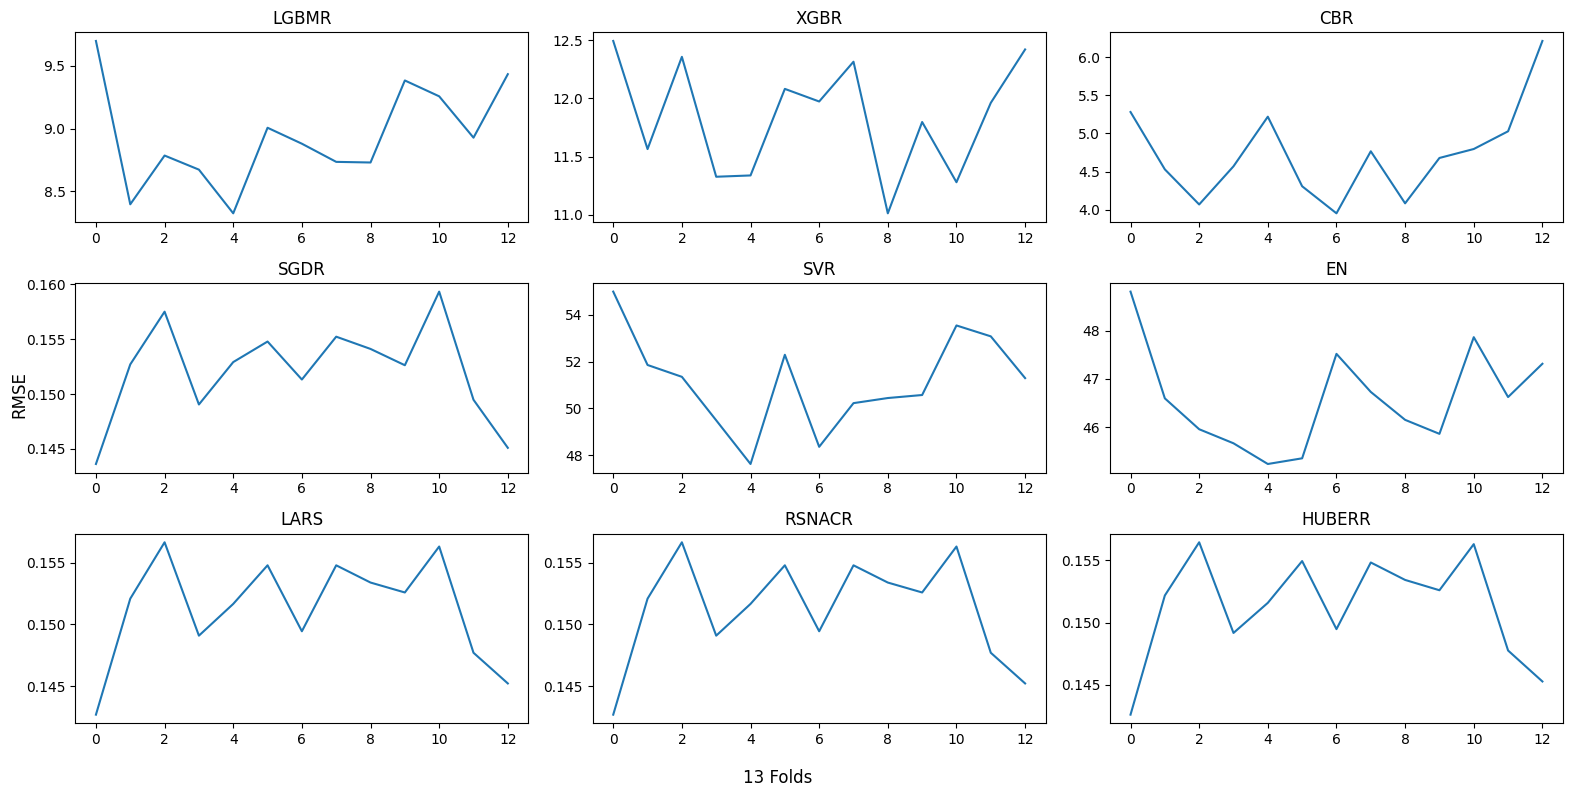

In [15]:


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))

for i, (model_scores, model_name) in enumerate(zip(cv_models_all, model_names)):
    ax = axes[i // 3, i % 3]
    ax.plot(model_scores)
    ax.set_title(model_name)

fig.supxlabel(f"{n_splits} Folds")
fig.supylabel("RMSE")
fig.tight_layout()
fig.show()

### PCA

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Step 2: Create a PCA instance and fit the scaled data
pca = PCA()
pca.fit(scaled_X)

# Step 3: Get the eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# Step 4: Sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[sorted_indices]

#### Variance explained

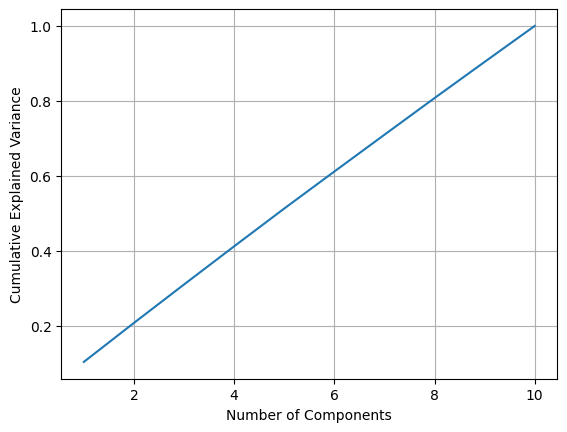

In [17]:
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cum_explained_variance) + 1), cum_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

#### Elbow method

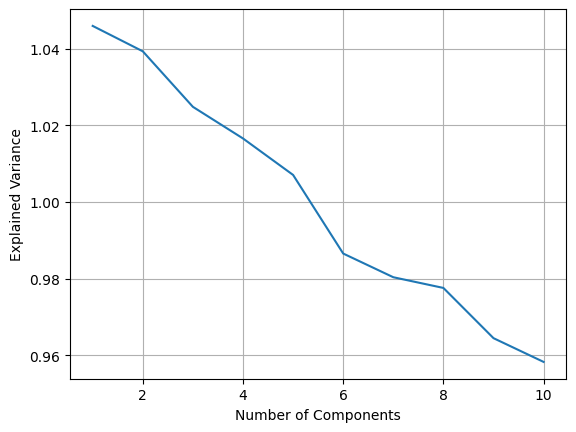

In [18]:
explained_variance = pca.explained_variance_
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

#### n Components

In [19]:
# Step 5: Choose the number of principal components to retain
num_components = 4  # Set the desired number of components

# Step 6: Project the data onto the selected principal components
selected_eigenvectors = sorted_eigenvectors[:num_components]
transformed_X = np.dot(scaled_X, selected_eigenvectors.T)

#### Cross Validation with 4 PCA Components

In [20]:
lgbm_scores = cross_val_score(LGBMRegressor(random_state=rs, verbose=-1), transformed_X, y, cv=kf, scoring=rmse)
print(f'LGBMR CV Score : {"{:.5f}".format(lgbm_scores.mean())}')

xgbr_scores = cross_val_score(XGBRegressor(random_state=rs), transformed_X, y, cv=kf, scoring=rmse)
print(f'XGBR CV Score : {"{:.5f}".format(xgbr_scores.mean())}')

cbr_scores = cross_val_score(CatBoostRegressor(random_state=rs, silent=True), transformed_X, y, cv=kf, scoring=rmse)
print(f'CBR CV Score : {"{:.5f}".format(cbr_scores.mean())}')

sgdr_scores = cross_val_score(SGDRegressor(random_state=rs, verbose=0), transformed_X, y, cv=kf, scoring=rmse)
print(f'SGDR CV Score : {"{:.5f}".format(sgdr_scores.mean())}')

svr_scores = cross_val_score(SVR(), transformed_X, y, cv=kf, scoring=rmse)
print(f'SVR CV Score : {"{:.5f}".format(svr_scores.mean())}')

en_scores = cross_val_score(ElasticNet(random_state=rs), transformed_X, y, cv=kf, scoring=rmse)
print(f'EN CV Score : {"{:.5f}".format(en_scores.mean())}')

lars_scores = cross_val_score(Lars(random_state=rs), transformed_X, y, cv=kf, scoring=rmse)
print(f'LARS CV Score : {"{:.5f}".format(lars_scores.mean())}')

rsnscr_scores = cross_val_score(RANSACRegressor(random_state=rs), transformed_X, y, cv=kf, scoring=rmse)
print(f'RANSACR CV Score : {"{:.5f}".format(rsnscr_scores.mean())}')

huber_scores = cross_val_score(HuberRegressor(), transformed_X, y, cv=kf, scoring=rmse)
print(f'HuberR CV Score : {"{:.5f}".format(huber_scores.mean())}')

cv_models_all = [lgbm_scores, xgbr_scores, cbr_scores, sgdr_scores, svr_scores, en_scores, lars_scores, rsnscr_scores, huber_scores]

LGBMR CV Score : 86.96991
XGBR CV Score : 89.34822
CBR CV Score : 86.98077
SGDR CV Score : 85.33861
SVR CV Score : 93.76905
EN CV Score : 92.83663
LARS CV Score : 85.34169
RANSACR CV Score : 92.12253
HuberR CV Score : 85.34060


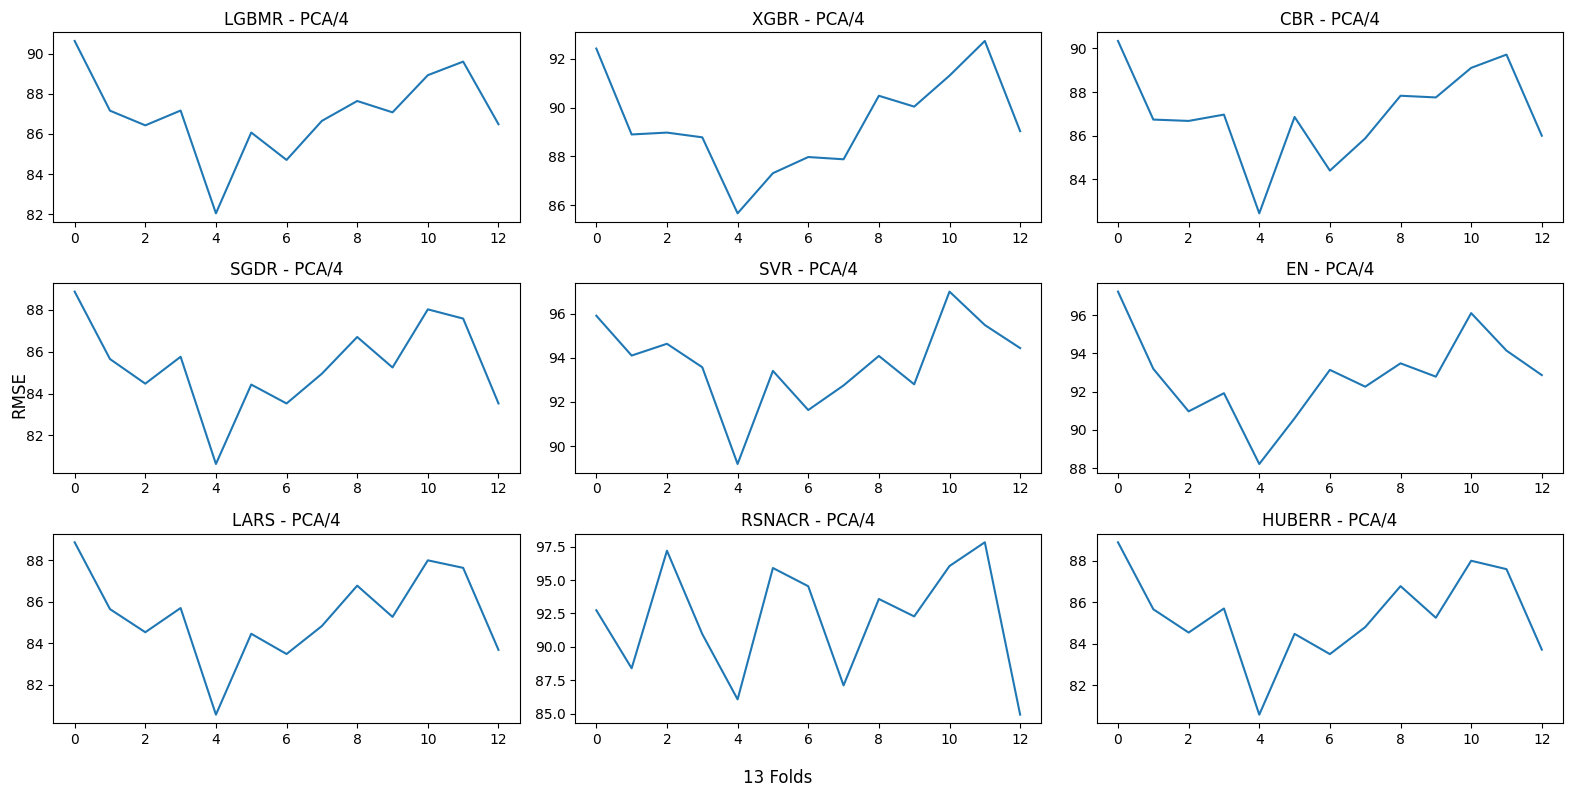

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))

for i, (model_scores, model_name) in enumerate(zip(cv_models_all, model_names)):
    ax = axes[i // 3, i % 3]
    ax.plot(model_scores)
    ax.set_title(model_name+" - PCA/4")

fig.supxlabel(f"{n_splits} Folds")
fig.supylabel("RMSE")
fig.tight_layout()
fig.show()

### Cross Validation with top features only

#### Removing outliers for selected features only (will save a few data points)

In [22]:
l, h = 0.15, 0.85
features = ['x0', 'x6', 'x7', 'x8']
train_clean = remove_outliers(df=train, features=features, low=l, high=h)

Currently removing outliers from: x0
Currently removing outliers from: x6
Currently removing outliers from: x7
Currently removing outliers from: x8


In [23]:
train_clean.reset_index()

,index,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,0,9214,-1.269584,-0.471276,1.271286,1.181464,-0.100392,1.449701,1.377916,-0.065368,-0.292402,-0.227562,-6.744388
1,1,9936,-3.345712,0.962012,-0.010381,-1.143822,2.144663,0.002984,-0.062975,0.239043,1.026711,0.937543,-209.017251
2,2,6148,-0.177312,-0.654352,1.139073,0.449924,-0.428796,0.956123,1.523470,-0.016801,0.279851,-0.183580,136.280877
3,3,3466,-0.465802,1.430401,0.565258,-0.882161,0.228255,-0.579749,1.538078,2.194240,-0.029758,0.686409,92.047959
4,4,6878,1.145984,0.663759,1.589677,0.773086,0.838778,1.354121,-0.156710,-0.403062,0.140580,-1.136642,91.349775
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11995,9941,1.209148,0.968248,-0.233942,-0.661826,0.068980,1.038689,1.342263,-0.475022,0.024588,-0.071629,216.940422
11996,11996,3835,-0.202524,-0.876634,-0.379980,1.378035,-0.602254,-1.158553,1.115208,0.291473,1.088164,-1.236181,156.244277
11997,11997,6101,0.577834,1.112086,-0.697342,0.123455,0.444490,-0.668361,-1.891849,0.695727,0.929277,-0.183775,-49.257565
11998,11998,5435,-0.315841,-0.391228,-0.213742,-0.171128,1.823233,1.261355,1.930175,0.929642,-0.181617,2.091590,127.117060


In [24]:
train_clean.shape

(12000, 12)

In [25]:
train_clean_removed = train_clean.drop(['x1', 'x2', 'x3', 'x4', 'x5', 'x9'], axis=1)
X_c, y_c = train_clean_removed.iloc[:,1:-1], train_clean_removed.iloc[:,-1]

In [26]:
lgbm_scores = cross_val_score(LGBMRegressor(random_state=rs, verbose=-1), X_c, y_c, cv=kf, scoring=rmse)
print(f'LGBMR CV Score : {"{:.5f}".format(lgbm_scores.mean())}')

xgbr_scores = cross_val_score(XGBRegressor(random_state=rs), X_c, y_c, cv=kf, scoring=rmse)
print(f'XGBR CV Score : {"{:.5f}".format(xgbr_scores.mean())}')

cbr_scores = cross_val_score(CatBoostRegressor(random_state=rs, silent=True), X_c, y_c, cv=kf, scoring=rmse)
print(f'CBR CV Score : {"{:.5f}".format(cbr_scores.mean())}')

sgdr_scores = cross_val_score(SGDRegressor(random_state=rs, verbose=0), X_c, y_c, cv=kf, scoring=rmse)
print(f'SGDR CV Score : {"{:.5f}".format(sgdr_scores.mean())}')

svr_scores = cross_val_score(SVR(), X_c, y_c, cv=kf, scoring=rmse)
print(f'SVR CV Score : {"{:.5f}".format(svr_scores.mean())}')

en_scores = cross_val_score(ElasticNet(random_state=rs), X_c, y_c, cv=kf, scoring=rmse)
print(f'EN CV Score : {"{:.5f}".format(en_scores.mean())}')

lars_scores = cross_val_score(Lars(random_state=rs), X_c, y_c, cv=kf, scoring=rmse)
print(f'LARS CV Score : {"{:.5f}".format(lars_scores.mean())}')

rsnscr_scores = cross_val_score(RANSACRegressor(random_state=rs), X_c, y_c, cv=kf, scoring=rmse)
print(f'RANSACR CV Score : {"{:.5f}".format(rsnscr_scores.mean())}')

huber_scores = cross_val_score(HuberRegressor(), X_c, y_c, cv=kf, scoring=rmse)
print(f'HuberR CV Score : {"{:.5f}".format(huber_scores.mean())}')

cv_models_all = [lgbm_scores, xgbr_scores, cbr_scores, sgdr_scores, svr_scores, en_scores, lars_scores, rsnscr_scores, huber_scores]

LGBMR CV Score : 8.73294
XGBR CV Score : 10.92538
CBR CV Score : 5.31336
SGDR CV Score : 0.15194
SVR CV Score : 36.92766
EN CV Score : 46.58775
LARS CV Score : 0.15124
RANSACR CV Score : 0.15124
HuberR CV Score : 0.15125


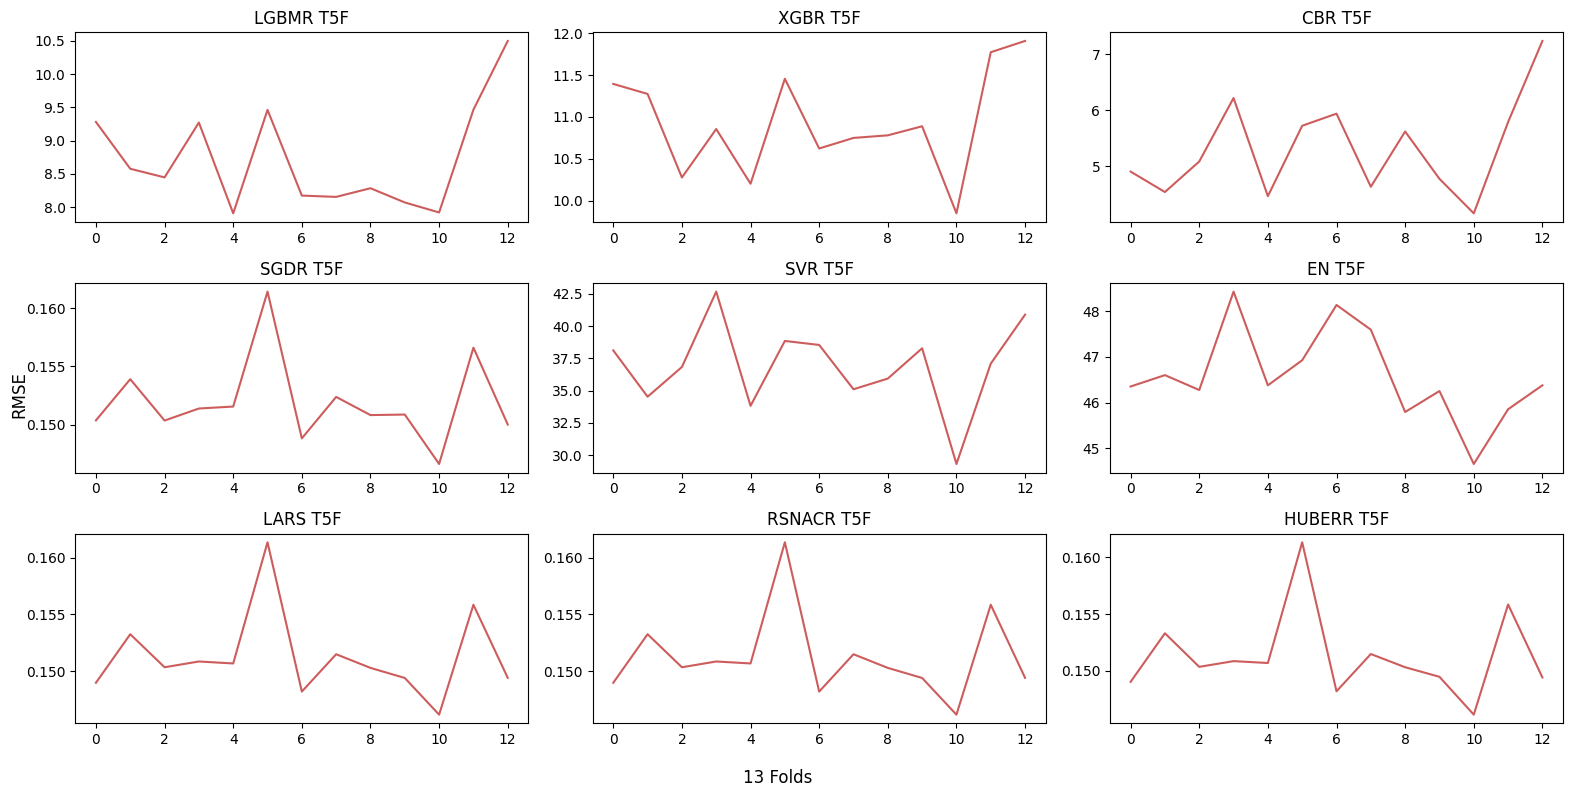

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))

for i, (model_scores, model_name) in enumerate(zip(cv_models_all, model_names)):
    ax = axes[i // 3, i % 3]
    ax.plot(model_scores, color='indianred')
    ax.set_title(model_name+' T5F')

fig.supxlabel(f"{n_splits} Folds")
fig.supylabel("RMSE")
fig.tight_layout()
fig.show()

### Hyperparameter Optimizations

#### Optuna for SGD Reg.

In [28]:
study_name = "SGDR-1/KF13"
n_trials = 300
n_splits = n_splits

# Define the objective function
def objective(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']),
        'penalty': trial.suggest_categorical('penalty', ['elasticnet', 'l2', 'l1']),
        'alpha': trial.suggest_float('alpha', 0.0001, 0.01),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
        'epsilon': trial.suggest_float('epsilon', 0.01, 0.1),
        'random_state': rs
    }

    model = SGDRegressor(**params)
    rmse_scores = []
    
    for train_index, test_index in kf.split(X_c):
        X_train, X_test = X_c.iloc[train_index], X_c.iloc[test_index]
        y_train, y_test = y_c[train_index], y_c[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(rmse_score(y_test, y_pred))

    mean_rmse = np.mean(rmse_scores)
    return mean_rmse

# Create the study and optimize
study = optuna.create_study(study_name=study_name, direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Print the best trial and its score
print(f"Best trial for SGDR 1: {study.best_trial.params}")
print(f"Best RMSE score for SGDR 1: {study.best_value}")

# Get the best parameters
sgdr_best_params = study.best_trial.params

# Plot the study
optuna.visualization.plot_optimization_history(study)

[I 2023-05-17 20:18:23,051] A new study created in memory with name: SGDR-1/KF13
[I 2023-05-17 20:18:23,636] Trial 0 finished with value: 0.15184616878917437 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.007222510862721516, 'l1_ratio': 0.3461045544709276, 'max_iter': 813, 'tol': 0.0008910512570056659, 'epsilon': 0.029509618738943207}. Best is trial 0 with value: 0.15184616878917437.
[I 2023-05-17 20:18:23,831] Trial 1 finished with value: 0.15133062121307006 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0007906039224051201, 'l1_ratio': 0.9136441946592717, 'max_iter': 349, 'tol': 0.0004971949698705509, 'epsilon': 0.08634112457395926}. Best is trial 1 with value: 0.15133062121307006.
[I 2023-05-17 20:18:24,075] Trial 2 finished with value: 0.5259278884665824 and parameters: {'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.006396131969445074, 'l1_ratio': 0.6483870220509385, 'max_iter': 379, 'tol': 0.000

Best trial for SGDR 1: {'loss': 'huber', 'penalty': 'l1', 'alpha': 0.00012002882295532048, 'l1_ratio': 0.9644363188292111, 'max_iter': 812, 'tol': 0.0009936986127746638, 'epsilon': 0.0961064350488646}
Best RMSE score for SGDR 1: 0.15122440570257362


#### Optuna for Hubber Reg.

In [29]:
study_name = "Huber-1/KF13"
n_trials = 300
n_splits = n_splits

# Define the objective function
def objective(trial):
    params = {
        'epsilon': trial.suggest_float('epsilon', 1.0, 2.0),
        'alpha': trial.suggest_float('alpha', 0.0001, 0.01),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'tol': trial.suggest_float('tol', 1e-5, 1e-3),
    }

    model = HuberRegressor(**params)
    rmse_scores = []
    
    for train_index, test_index in kf.split(X_c):
        X_train, X_test = X_c.iloc[train_index], X_c.iloc[test_index]
        y_train, y_test = y_c[train_index], y_c[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(rmse_score(y_test, y_pred))

    mean_rmse = np.mean(rmse_scores)
    return mean_rmse

# Create the study and optimize
study = optuna.create_study(study_name=study_name, direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Print the best trial and its score
print(f"Best trial for Huber: {study.best_trial.params}")
print(f"Best RMSE score for Huber: {study.best_value}")

# Get the best parameters
hubr_best_params = study.best_trial.params

# Plot the study
optuna.visualization.plot_optimization_history(study)

[I 2023-05-17 20:59:54,408] A new study created in memory with name: Huber-1/KF13
[I 2023-05-17 20:59:55,677] Trial 0 finished with value: 0.1512615883935175 and parameters: {'epsilon': 1.0830358046476074, 'alpha': 0.005854371882728717, 'max_iter': 298, 'tol': 0.0006453725226922603}. Best is trial 0 with value: 0.1512615883935175.
[I 2023-05-17 20:59:56,805] Trial 1 finished with value: 0.15124377413668896 and parameters: {'epsilon': 1.9838743101005392, 'alpha': 0.005688596629952543, 'max_iter': 973, 'tol': 0.0006038729413853357}. Best is trial 1 with value: 0.15124377413668896.
[I 2023-05-17 20:59:57,943] Trial 2 finished with value: 0.1512616636148671 and parameters: {'epsilon': 1.0850201281204197, 'alpha': 0.006142383812765098, 'max_iter': 741, 'tol': 0.0005914839960115651}. Best is trial 1 with value: 0.15124377413668896.
[I 2023-05-17 20:59:59,024] Trial 3 finished with value: 0.15126091324340893 and parameters: {'epsilon': 1.0226212169755504, 'alpha': 0.002315972414918077, 'max_i

Best trial for Huber: {'epsilon': 1.9999907927583032, 'alpha': 0.0006694725879973159, 'max_iter': 559, 'tol': 0.0002202045481737567}
Best RMSE score for Huber: 0.15124357285549273


#### Optuna for RSNSA Reg.

In [30]:
study_name = "RSNSA-1/KF13"
n_trials = 300
n_splits = n_splits

def objective(trial):
    params = {
        'min_samples': trial.suggest_int('min_samples', 1, 100),
        'residual_threshold': trial.suggest_float('residual_threshold', 0.0, 2.0),
        'max_trials': trial.suggest_int('max_trials', 1, 100),
        'stop_probability': trial.suggest_float('stop_probability', 0.5, 0.99),
        'loss': trial.suggest_categorical('loss', ['absolute_error', 'squared_error']),
        'random_state': rs
    }
        
    model = RANSACRegressor(estimator=LinearRegression(), **params)
    rmse_scores = []
    
    for train_index, test_index in kf.split(X_c):
        X_train, X_test = X_c.iloc[train_index], X_c.iloc[test_index]
        y_train, y_test = y_c[train_index], y_c[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(rmse_score(y_test, y_pred))

    mean_rmse = np.mean(rmse_scores)
    return mean_rmse

# Create the study and optimize
study = optuna.create_study(study_name=study_name, direction='minimize')
study.optimize(objective, n_trials=n_trials)

# Print the best trial and its score
print(f"Best trial for RSNSA: {study.best_trial.params}")
print(f"Best RMSE score for RSNSA: {study.best_value}")

# Get the best parameters
rsnsa_best_params = study.best_trial.params

# Plot the study
optuna.visualization.plot_optimization_history(study)

[I 2023-05-17 21:06:19,459] A new study created in memory with name: RSNSA-1/KF13
[I 2023-05-17 21:06:19,798] Trial 0 finished with value: 0.1512407376132639 and parameters: {'min_samples': 66, 'residual_threshold': 0.6814467536998088, 'max_trials': 70, 'stop_probability': 0.753673673048346, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.1512407376132639.
[I 2023-05-17 21:06:22,583] Trial 1 finished with value: 38.9394156934594 and parameters: {'min_samples': 2, 'residual_threshold': 0.11031671764450213, 'max_trials': 70, 'stop_probability': 0.5255088634391191, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.1512407376132639.
[I 2023-05-17 21:06:22,921] Trial 2 finished with value: 0.15124122299801834 and parameters: {'min_samples': 57, 'residual_threshold': 1.427567055451897, 'max_trials': 27, 'stop_probability': 0.656366720722283, 'loss': 'squared_error'}. Best is trial 0 with value: 0.1512407376132639.
[I 2023-05-17 21:06:23,629] Trial 3 finished with value: 1.044

Best trial for RSNSA: {'min_samples': 13, 'residual_threshold': 0.46009146333034195, 'max_trials': 16, 'stop_probability': 0.5312424037427301, 'loss': 'squared_error'}
Best RMSE score for RSNSA: 0.15121850992080993


### Best Params for all 4

In [31]:
sgdr_params = {'loss': 'huber',
               'penalty': 'l1',
               'alpha': 0.00025262140858848636,
               'l1_ratio': 0.456027083558146,
               'max_iter': 999,
               'tol': 0.0002553392247069451,
               'epsilon': 0.08735355655286767}

huber_params = {'epsilon': 1.9997748237897144,
                'alpha': 0.00041436627045792114,
                'max_iter': 221,
                'tol': 0.000757667687008929}

rsnsa_params = {'estimator': LinearRegression(),
                'min_samples': 5,
                'residual_threshold': 0.8400987630435907,
                'max_trials': 88,
                'stop_probability': 0.9408683129008064,
                'loss': 'squared_error'}

### END OF PART II